Parameters:
  Stock Price (S): $100.00
  Strike Price (K): $100.00
  Time to Expiration (T): 1.00 years
  Risk-Free Rate (r): 5.00%
  Volatility (σ): 20.00%
  Dividend Yield (q): 1.00%

Option Prices:
  Call Option: $9.8263
  Put Option: $5.9443

Call Option Greeks:
  Delta: 0.611763
  Gamma: 0.018880
  Vega: 0.377593
  Theta: -0.015703
  Rho: 0.513500

Put Option Greeks:
  Delta: -0.378287
  Gamma: 0.018880
  Vega: 0.377593
  Theta: -0.005385
  Rho: -0.437729

Implied Volatility Test:
  Option Price: $10.8089
  Implied Volatility: 22.60%

Visualizing put-call parity:
Put-Call Parity Comparison:
  Option Type  BS Price  Parity Price    Difference
0        Call  9.826298      9.826298 -7.105427e-15
1         Put  5.944257      5.944257 -7.105427e-15

Put-Call Parity Formula:
C + K*e^(-r*T) = P + S*e^(-q*T)
9.8263 + 100.00*e^(-0.0500*1.00) = 5.9443 + 100.00*e^(-0.0100*1.00)
9.8263 + 95.1229 = 5.9443 + 99.0050
104.9492 = 104.9492


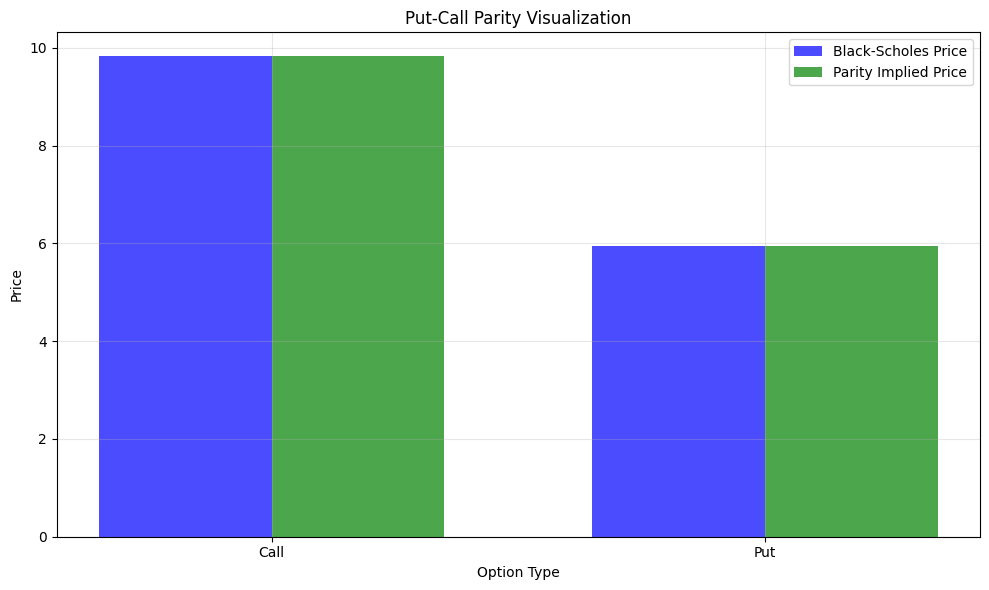


Generating plots...


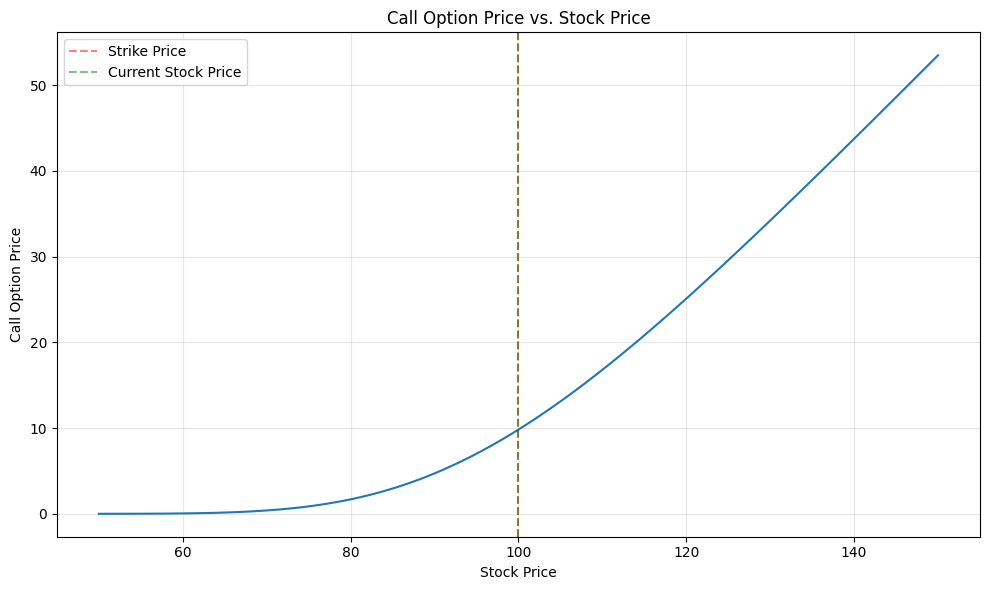

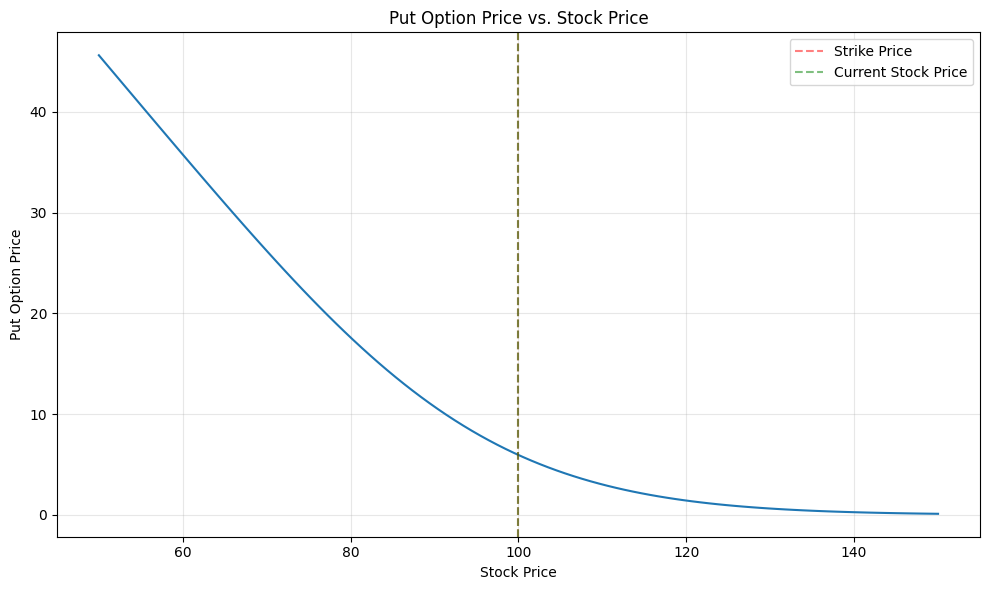

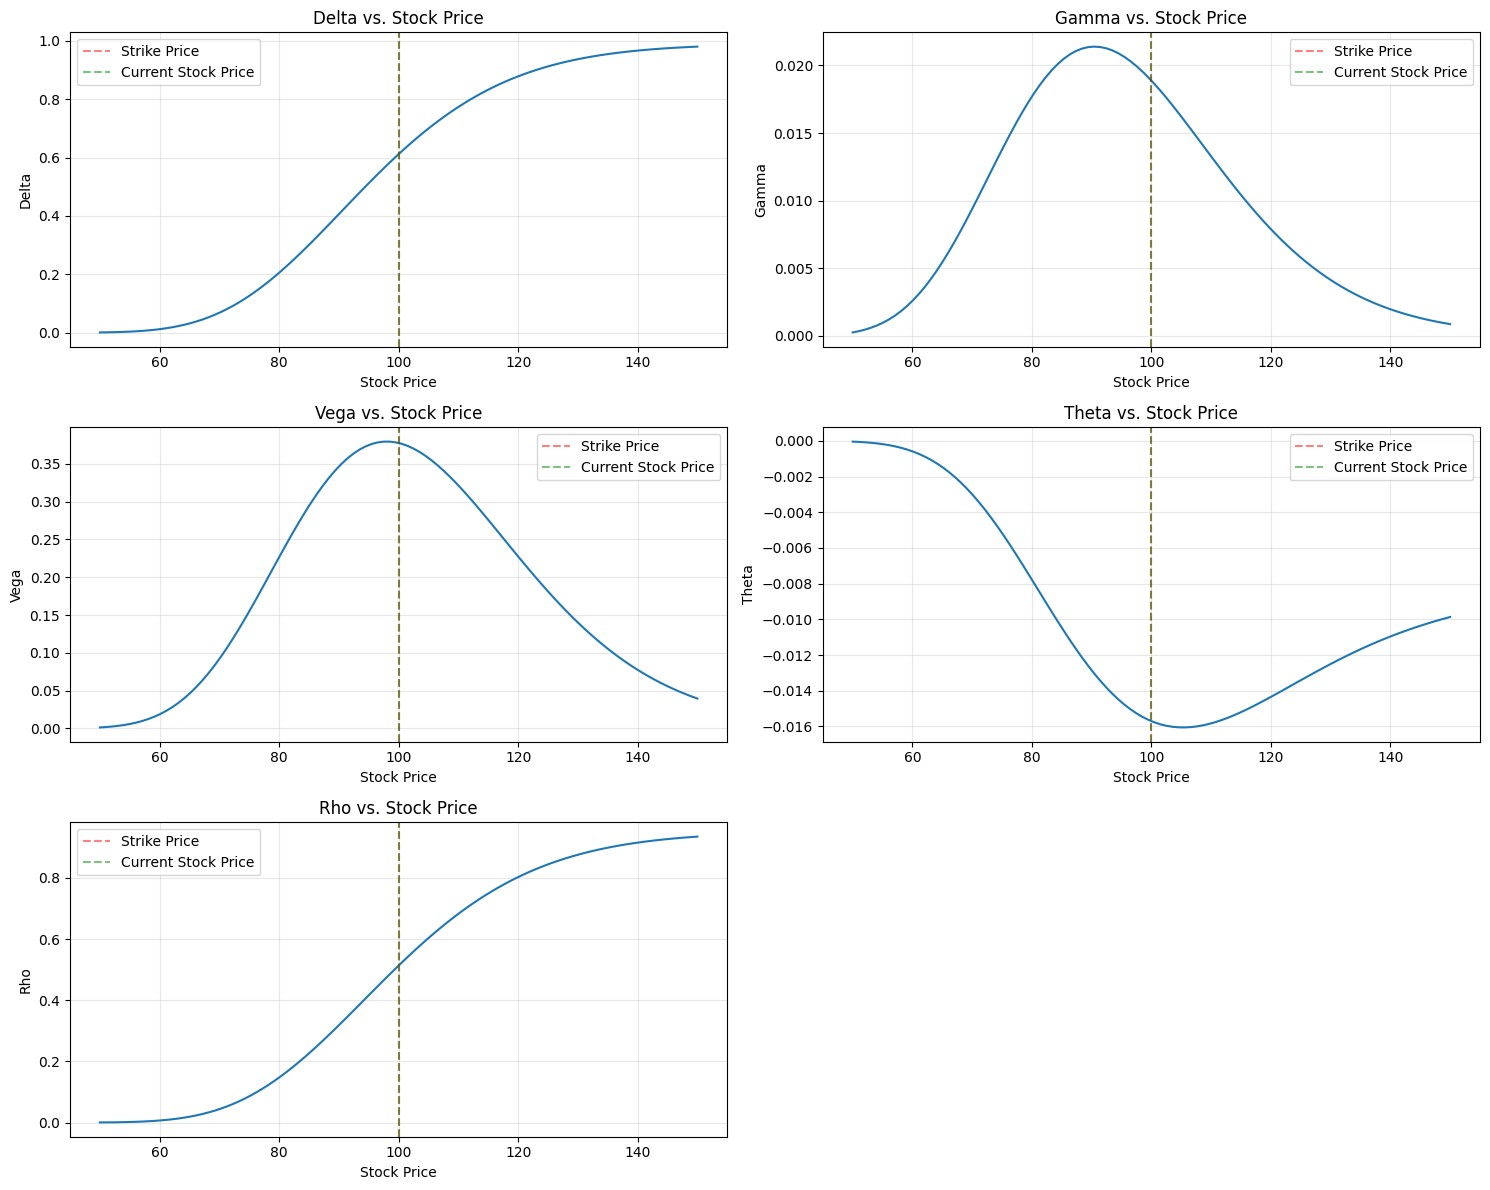

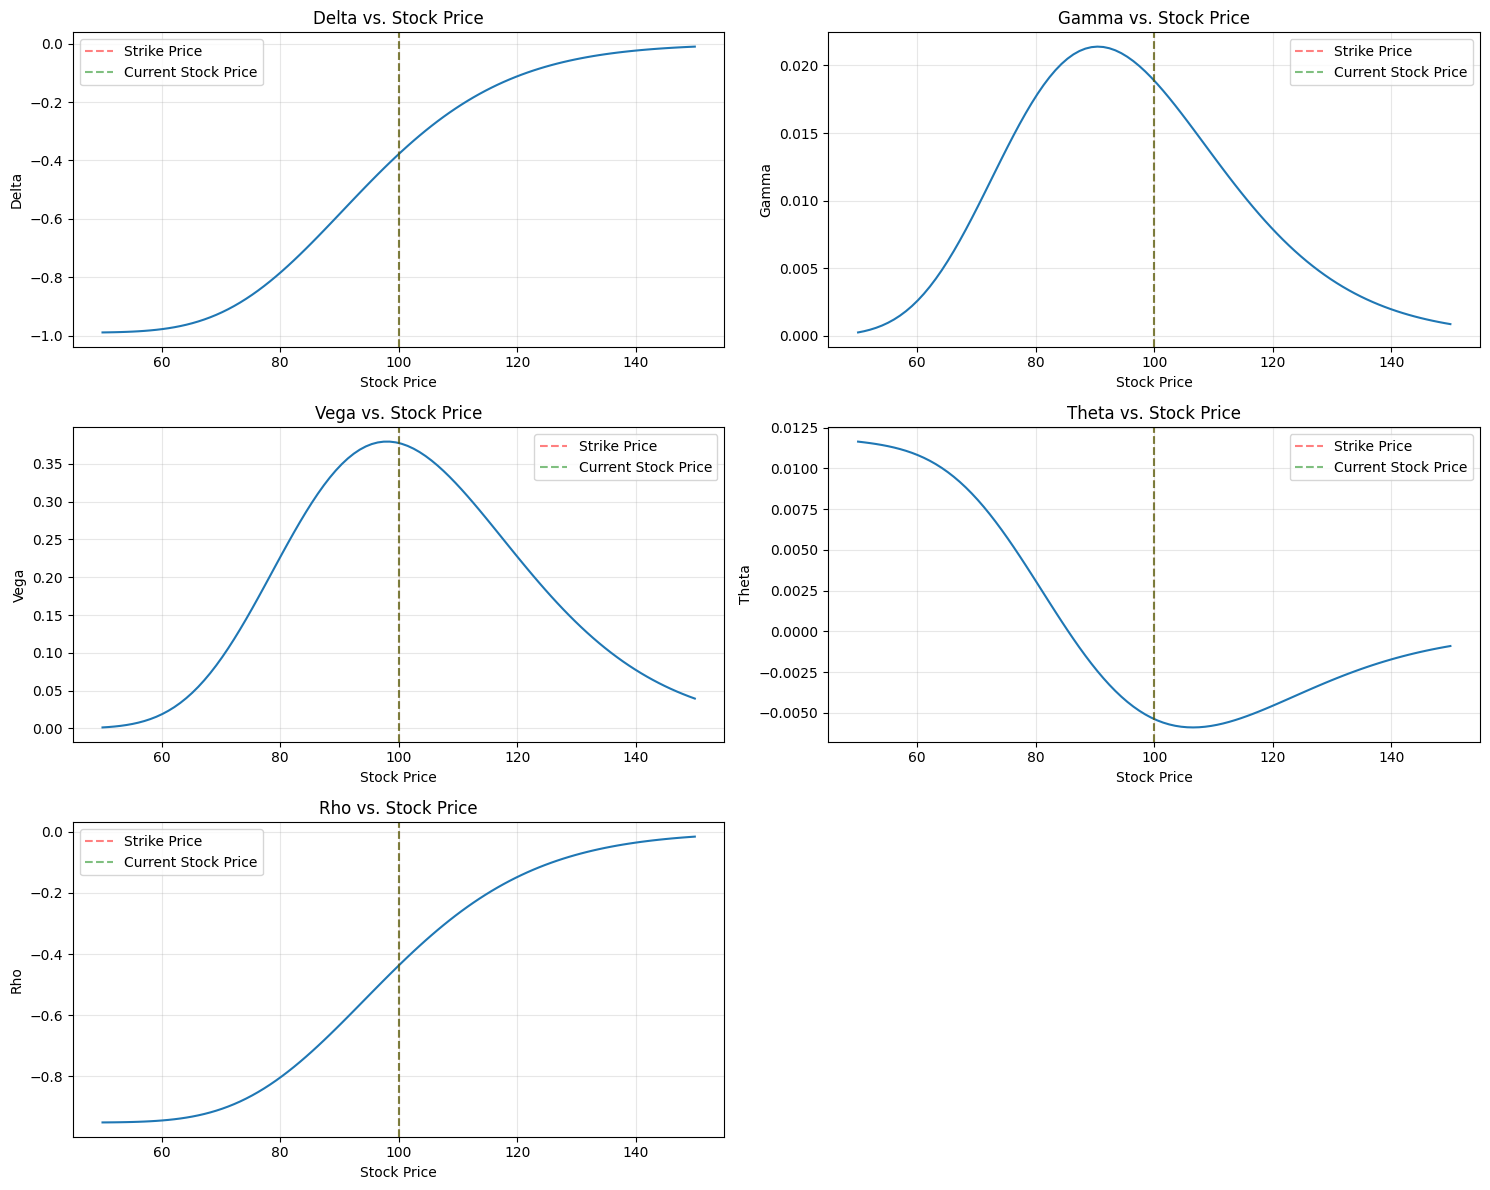

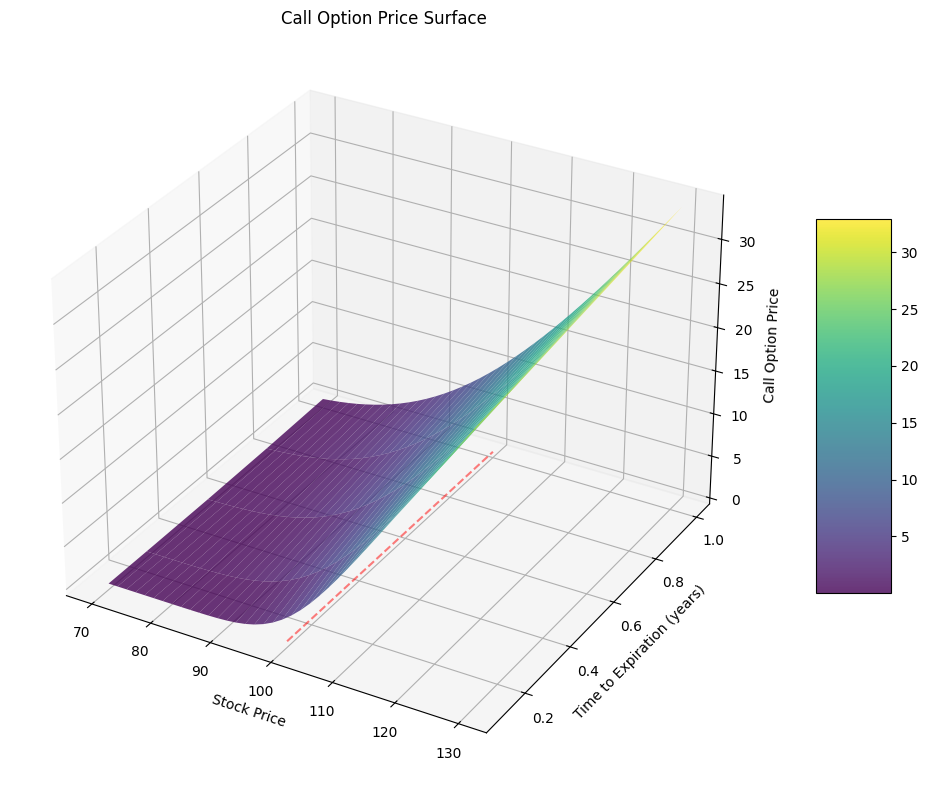

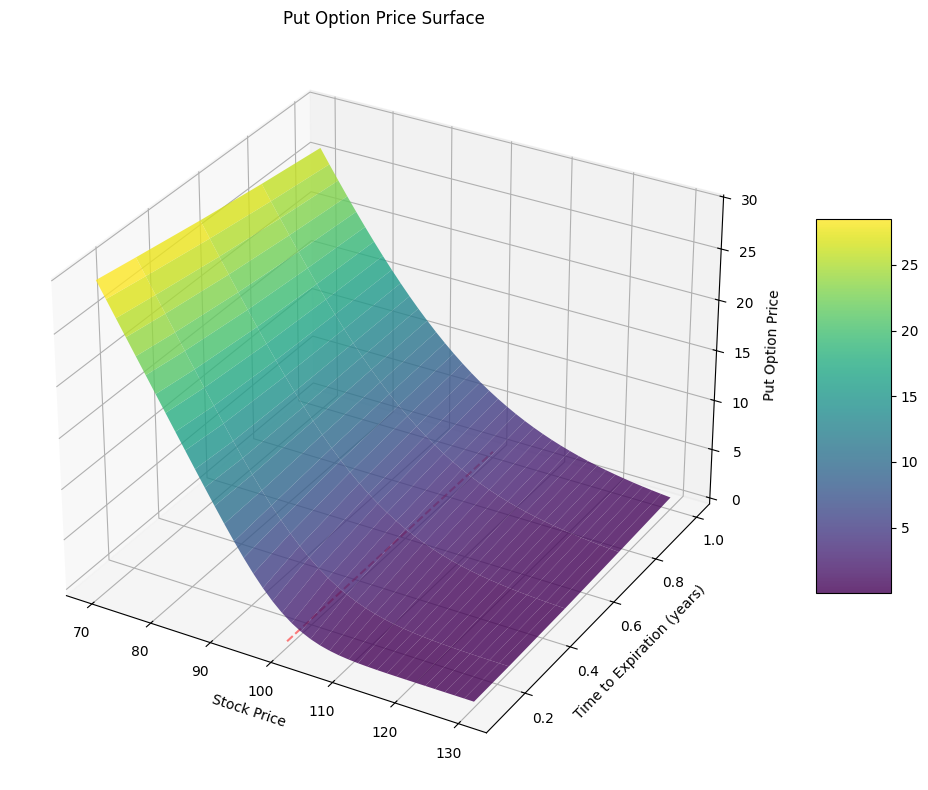

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from typing import Literal, Dict, List, Union, Tuple


class BlackScholes:
    """
    A class for pricing European options using the Black-Scholes model
    and calculating option Greeks.
    """
    
    def __init__(self, 
                 S: float, 
                 K: float, 
                 T: float, 
                 r: float, 
                 sigma: float, 
                 q: float = 0.0):
        """
        Initialize the Black-Scholes model with option parameters
        
        Parameters:
        -----------
        S : float
            Current stock price
        K : float
            Option strike price
        T : float
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annual, expressed as decimal)
        sigma : float
            Volatility of the underlying stock (annual, expressed as decimal)
        q : float, optional
            Dividend yield (annual, expressed as decimal), default is 0.0
        """
        self.S = S              # Stock price
        self.K = K              # Strike price
        self.T = T              # Time to expiration in years
        self.r = r              # Risk-free rate
        self.sigma = sigma      # Volatility
        self.q = q              # Dividend yield
        
        # Calculate d1 and d2 which are used in many formulas
        self._update_d1_d2()
        
    def _update_d1_d2(self):
        """Calculate the d1 and d2 components of the Black-Scholes formula"""
        if self.T <= 0:
            # Handle special case of expired option
            self.d1 = np.nan
            self.d2 = np.nan
            return
            
        sigma_sqrt_T = self.sigma * np.sqrt(self.T)
        self.d1 = (np.log(self.S / self.K) + 
                  (self.r - self.q + 0.5 * self.sigma**2) * self.T) / sigma_sqrt_T
        self.d2 = self.d1 - sigma_sqrt_T
    
    def price(self, option_type: str) -> float:
        """
        Calculate the option price using Black-Scholes formula
        
        Parameters:
        -----------
        option_type : str
            'call' for call option or 'put' for put option
            
        Returns:
        --------
        float
            Theoretical price of the option
        """
        option_type = option_type.lower()
        
        if self.T <= 0:
            # Handle special case of expired option
            if option_type == 'call':
                return max(0, self.S - self.K)
            else:
                return max(0, self.K - self.S)
        
        # Calculate Option Price
        if option_type == 'call':
            price = (self.S * np.exp(-self.q * self.T) * norm.cdf(self.d1) - 
                     self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2))
        elif option_type == 'put':
            price = (self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2) - 
                     self.S * np.exp(-self.q * self.T) * norm.cdf(-self.d1))
        else:
            raise ValueError("option_type must be 'call' or 'put'")
            
        return price
    
    def delta(self, option_type: str) -> float:
        """
        Calculate the delta of the option
        Delta measures the rate of change of option price with respect to the underlying asset price
        
        Parameters:
        -----------
        option_type : str
            'call' for call option or 'put' for put option
            
        Returns:
        --------
        float
            Delta value of the option
        """
        option_type = option_type.lower()
        
        if self.T <= 0:
            # Handle special case of expired option
            if option_type == 'call':
                return 1.0 if self.S > self.K else 0.0
            else:
                return -1.0 if self.S < self.K else 0.0
        
        if option_type == 'call':
            return np.exp(-self.q * self.T) * norm.cdf(self.d1)
        elif option_type == 'put':
            return np.exp(-self.q * self.T) * (norm.cdf(self.d1) - 1)
        else:
            raise ValueError("option_type must be 'call' or 'put'")
    
    def gamma(self) -> float:
        """
        Calculate the gamma of the option
        Gamma measures the rate of change of delta with respect to the underlying asset price
        
        Returns:
        --------
        float
            Gamma value of the option (same for call and put)
        """
        if self.T <= 0:
            # Handle special case of expired option
            return 0.0
            
        return (np.exp(-self.q * self.T) * norm.pdf(self.d1)) / (self.S * self.sigma * np.sqrt(self.T))
    
    def vega(self) -> float:
        """
        Calculate the vega of the option
        Vega measures the rate of change of option price with respect to volatility
        
        Returns:
        --------
        float
            Vega value of the option (same for call and put)
        """
        if self.T <= 0:
            # Handle special case of expired option
            return 0.0
            
        return self.S * np.exp(-self.q * self.T) * norm.pdf(self.d1) * np.sqrt(self.T) / 100
    
    def theta(self, option_type: str) -> float:
        """
        Calculate the theta of the option
        Theta measures the rate of change of option price with respect to time to expiration
        
        Parameters:
        -----------
        option_type : str
            'call' for call option or 'put' for put option
            
        Returns:
        --------
        float
            Theta value of the option (annualized)
        """
        option_type = option_type.lower()
        
        if self.T <= 0:
            # Handle special case of expired option
            return 0.0
        
        term1 = -(self.S * np.exp(-self.q * self.T) * norm.pdf(self.d1) * self.sigma) / (2 * np.sqrt(self.T))
        
        if option_type == 'call':
            term2 = -self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)
            term3 = self.q * self.S * np.exp(-self.q * self.T) * norm.cdf(self.d1)
        elif option_type == 'put':
            term2 = self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2)
            term3 = -self.q * self.S * np.exp(-self.q * self.T) * norm.cdf(-self.d1)
        else:
            raise ValueError("option_type must be 'call' or 'put'")
            
        # Return value is divided by 365 to get daily theta rather than annual
        return (term1 + term2 + term3) / 365
    
    def rho(self, option_type: str) -> float:
        """
        Calculate the rho of the option
        Rho measures the rate of change of option price with respect to interest rate
        
        Parameters:
        -----------
        option_type : str
            'call' for call option or 'put' for put option
            
        Returns:
        --------
        float
            Rho value of the option
        """
        option_type = option_type.lower()
        
        if self.T <= 0:
            # Handle special case of expired option
            return 0.0
        
        if option_type == 'call':
            return self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(self.d2) / 100
        elif option_type == 'put':
            return -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-self.d2) / 100
        else:
            raise ValueError("option_type must be 'call' or 'put'")
    
    def implied_volatility(self, option_price: float, option_type: str, 
                           max_iterations: int = 100, precision: float = 1e-8) -> float:
        """
        Calculate implied volatility from option price using Newton-Raphson method
        
        Parameters:
        -----------
        option_price : float
            Market price of the option
        option_type : str
            'call' for call option or 'put' for put option
        max_iterations : int, optional
            Maximum number of iterations for the algorithm, default is 100
        precision : float, optional
            Desired precision for the result, default is 1e-8
            
        Returns:
        --------
        float
            Implied volatility (sigma) that produces the given option price
        """
        option_type = option_type.lower()
        
        if self.T <= 0:
            return np.nan
            
        # Save the original volatility to restore later
        original_sigma = self.sigma
        
        # Start with a reasonable guess
        self.sigma = 0.2
        
        for i in range(max_iterations):
            # Calculate option price with current sigma
            price = self.price(option_type)
            price_diff = price - option_price
            
            # If within precision, return result
            if abs(price_diff) < precision:
                result = self.sigma
                self.sigma = original_sigma  # Restore original sigma
                self._update_d1_d2()
                return result
            
            # Calculate vega for Newton-Raphson update
            v = self.vega() * 100  # Convert to same scale
            
            # Prevent division by zero
            if abs(v) < 1e-10:
                self.sigma = original_sigma  # Restore original sigma
                self._update_d1_d2()
                return np.nan
            
            # Update sigma using Newton-Raphson formula
            new_sigma = self.sigma - price_diff / v
            
            # Ensure sigma stays positive and not too extreme
            if new_sigma <= 0.001:
                new_sigma = 0.001
            elif new_sigma > 5:
                new_sigma = 5
                
            # If change is small enough, we're done
            if abs(new_sigma - self.sigma) < precision:
                result = new_sigma
                self.sigma = original_sigma  # Restore original sigma
                self._update_d1_d2()
                return result
                
            self.sigma = new_sigma
            self._update_d1_d2()
            
        # Restore original sigma if no convergence
        self.sigma = original_sigma
        self._update_d1_d2()
        
        # Return the last value if no convergence
        return self.sigma
    
    def calculate_all_greeks(self, option_type: str) -> Dict[str, float]:
        """
        Calculate and return all option Greeks in a dictionary
        
        Parameters:
        -----------
        option_type : str
            'call' for call option or 'put' for put option
            
        Returns:
        --------
        Dict[str, float]
            Dictionary containing all calculated Greeks
        """
        return {
            'price': self.price(option_type),
            'delta': self.delta(option_type),
            'gamma': self.gamma(),
            'vega': self.vega(),
            'theta': self.theta(option_type),
            'rho': self.rho(option_type)
        }
    
    def plot_price_vs_stock_price(self, option_type: str, 
                                 price_range: float = 0.5) -> None:
        """
        Plot option price as a function of stock price
        
        Parameters:
        -----------
        option_type : str
            'call' for call option or 'put' for put option
        price_range : float, optional
            Range of stock prices to plot as a fraction of current price, default is 0.5
            
        Returns:
        --------
        None
        """
        option_type = option_type.lower()
        
        # Create range of stock prices
        min_price = self.S * (1 - price_range)
        max_price = self.S * (1 + price_range)
        stock_prices = np.linspace(min_price, max_price, 100)
        
        option_prices = []
        
        # Calculate option price for each stock price
        original_S = self.S
        for price in stock_prices:
            self.S = price
            self._update_d1_d2()
            option_prices.append(self.price(option_type))
        
        # Restore original stock price
        self.S = original_S
        self._update_d1_d2()
        
        # Create plot
        plt.figure(figsize=(10, 6))
        plt.plot(stock_prices, option_prices)
        plt.axvline(x=self.K, color='r', linestyle='--', alpha=0.5, label='Strike Price')
        plt.axvline(x=original_S, color='g', linestyle='--', alpha=0.5, label='Current Stock Price')
        plt.xlabel('Stock Price')
        plt.ylabel(f'{option_type.capitalize()} Option Price')
        plt.title(f'{option_type.capitalize()} Option Price vs. Stock Price')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_greeks_vs_stock_price(self, option_type: str, 
                                  price_range: float = 0.5) -> None:
        """
        Plot all Greeks as functions of stock price
        
        Parameters:
        -----------
        option_type : str
            'call' for call option or 'put' for put option
        price_range : float, optional
            Range of stock prices to plot as a fraction of current price, default is 0.5
            
        Returns:
        --------
        None
        """
        option_type = option_type.lower()
        
        # Create range of stock prices
        min_price = self.S * (1 - price_range)
        max_price = self.S * (1 + price_range)
        stock_prices = np.linspace(min_price, max_price, 100)
        
        # Dictionaries to store results
        results = {
            'delta': [],
            'gamma': [],
            'vega': [],
            'theta': [],
            'rho': []
        }
        
        # Calculate Greeks for each stock price
        original_S = self.S
        for price in stock_prices:
            self.S = price
            self._update_d1_d2()
            results['delta'].append(self.delta(option_type))
            results['gamma'].append(self.gamma())
            results['vega'].append(self.vega())
            results['theta'].append(self.theta(option_type))
            results['rho'].append(self.rho(option_type))
        
        # Restore original stock price
        self.S = original_S
        self._update_d1_d2()
        
        # Create subplots
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
        axes = axes.flatten()
        
        # Plot each Greek
        for i, (greek, values) in enumerate(results.items()):
            if i < len(axes):
                ax = axes[i]
                ax.plot(stock_prices, values)
                ax.axvline(x=self.K, color='r', linestyle='--', alpha=0.5, label='Strike Price')
                ax.axvline(x=original_S, color='g', linestyle='--', alpha=0.5, label='Current Stock Price')
                ax.set_xlabel('Stock Price')
                ax.set_ylabel(greek.capitalize())
                ax.set_title(f'{greek.capitalize()} vs. Stock Price')
                ax.grid(True, alpha=0.3)
                ax.legend()
        
        # Hide the last subplot if there are an odd number of Greeks
        if len(results) < len(axes):
            axes[-1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def plot_price_surface(self, option_type: str,
                          stock_range: float = 0.3,
                          time_range: List[float] = None) -> None:
        """
        Plot 3D surface of option price as a function of stock price and time to expiration
        
        Parameters:
        -----------
        option_type : str
            'call' for call option or 'put' for put option
        stock_range : float, optional
            Range of stock prices to plot as a fraction of current price, default is 0.3
        time_range : List[float], optional
            Range of times to expiration to plot in years, default is [0.1, 0.25, 0.5, 0.75, 1.0]
            
        Returns:
        --------
        None
        """
        option_type = option_type.lower()
        
        if time_range is None:
            time_range = [0.1, 0.25, 0.5, 0.75, 1.0]
        
        # Create range of stock prices
        min_price = self.S * (1 - stock_range)
        max_price = self.S * (1 + stock_range)
        stock_prices = np.linspace(min_price, max_price, 40)
        
        # Create meshgrid
        X, Y = np.meshgrid(stock_prices, time_range)
        Z = np.zeros_like(X)
        
        # Calculate option price for each combination
        original_S = self.S
        original_T = self.T
        
        for i, t in enumerate(time_range):
            self.T = t
            for j, s in enumerate(stock_prices):
                self.S = s
                self._update_d1_d2()
                Z[i, j] = self.price(option_type)
        
        # Restore original values
        self.S = original_S
        self.T = original_T
        self._update_d1_d2()
        
        # Create 3D plot
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot surface
        surface = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')
        
        # Add strike price plane
        x_plane = np.ones_like(time_range) * self.K
        y_plane = time_range
        z_plane = np.zeros((len(time_range), 2))
        
        for i, t in enumerate(time_range):
            self.T = t
            self.S = self.K
            self._update_d1_d2()
            z_plane[i, 0] = 0
            z_plane[i, 1] = self.price(option_type) * 2  # Extend above the surface
        
        # Plot strike price reference
        ax.plot(x_plane, y_plane, z_plane[:, 0], 'r--', alpha=0.5)
        
        # Labels and title
        ax.set_xlabel('Stock Price')
        ax.set_ylabel('Time to Expiration (years)')
        ax.set_zlabel(f'{option_type.capitalize()} Option Price')
        ax.set_title(f'{option_type.capitalize()} Option Price Surface')
        
        # Add colorbar
        fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def visualize_put_call_parity(S: float, K: float, T: float, r: float, 
                                sigma: float, q: float = 0.0) -> None:
        """
        Visualize the put-call parity relationship
        
        Parameters:
        -----------
        S : float
            Current stock price
        K : float
            Option strike price
        T : float
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annual, expressed as decimal)
        sigma : float
            Volatility of the underlying stock (annual, expressed as decimal)
        q : float, optional
            Dividend yield (annual, expressed as decimal), default is 0.0
            
        Returns:
        --------
        None
        """
        # Initialize Black-Scholes model
        bs = BlackScholes(S, K, T, r, sigma, q)
        
        # Calculate call and put prices
        call_price = bs.price('call')
        put_price = bs.price('put')
        
        # Calculate theoretical put price from put-call parity
        theoretical_put = call_price - S * np.exp(-q * T) + K * np.exp(-r * T)
        
        # Calculate theoretical call price from put-call parity
        theoretical_call = put_price + S * np.exp(-q * T) - K * np.exp(-r * T)
        
        # Create a data frame for display
        data = {
            'Option Type': ['Call', 'Put'],
            'BS Price': [call_price, put_price],
            'Parity Price': [theoretical_call, theoretical_put],
            'Difference': [call_price - theoretical_call, put_price - theoretical_put]
        }
        
        df = pd.DataFrame(data)
        
        # Print the table
        print("Put-Call Parity Comparison:")
        print(df)
        print("\nPut-Call Parity Formula:")
        print(f"C + K*e^(-r*T) = P + S*e^(-q*T)")
        print(f"{call_price:.4f} + {K:.2f}*e^(-{r:.4f}*{T:.2f}) = {put_price:.4f} + {S:.2f}*e^(-{q:.4f}*{T:.2f})")
        print(f"{call_price:.4f} + {K * np.exp(-r * T):.4f} = {put_price:.4f} + {S * np.exp(-q * T):.4f}")
        print(f"{call_price + K * np.exp(-r * T):.4f} = {put_price + S * np.exp(-q * T):.4f}")
        
        # Create bar chart
        plt.figure(figsize=(10, 6))
        x = ['Call', 'Put']
        y1 = [call_price, put_price]
        y2 = [theoretical_call, theoretical_put]
        
        x_pos = np.arange(len(x))
        width = 0.35
        
        plt.bar(x_pos - width/2, y1, width, color='b', alpha=0.7, label='Black-Scholes Price')
        plt.bar(x_pos + width/2, y2, width, color='g', alpha=0.7, label='Parity Implied Price')
        
        plt.xlabel('Option Type')
        plt.ylabel('Price')
        plt.title('Put-Call Parity Visualization')
        plt.xticks(x_pos, x)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# Example usage
if __name__ == "__main__":
    # Initialize model with example parameters
    S = 100.0    # Stock price
    K = 100.0    # Strike price
    T = 1.0      # Time to expiration in years
    r = 0.05     # Risk-free rate (5%)
    sigma = 0.2  # Volatility (20%)
    q = 0.01     # Dividend yield (1%)
    
    # Create Black-Scholes model
    bs = BlackScholes(S, K, T, r, sigma, q)
    
    # Calculate call and put option prices
    call_price = bs.price('call')
    put_price = bs.price('put')
    
    print(f"Parameters:")
    print(f"  Stock Price (S): ${S:.2f}")
    print(f"  Strike Price (K): ${K:.2f}")
    print(f"  Time to Expiration (T): {T:.2f} years")
    print(f"  Risk-Free Rate (r): {r:.2%}")
    print(f"  Volatility (σ): {sigma:.2%}")
    print(f"  Dividend Yield (q): {q:.2%}")
    print("")
    
    print(f"Option Prices:")
    print(f"  Call Option: ${call_price:.4f}")
    print(f"  Put Option: ${put_price:.4f}")
    print("")
    
    # Calculate and display Greeks for call
    print("Call Option Greeks:")
    call_greeks = bs.calculate_all_greeks('call')
    for greek, value in call_greeks.items():
        if greek != 'price':  # Already printed price above
            print(f"  {greek.capitalize()}: {value:.6f}")
    print("")
    
    # Calculate and display Greeks for put
    print("Put Option Greeks:")
    put_greeks = bs.calculate_all_greeks('put')
    for greek, value in put_greeks.items():
        if greek != 'price':  # Already printed price above
            print(f"  {greek.capitalize()}: {value:.6f}")
    print("")
    
    # Calculate implied volatility from option price
    test_price = call_price * 1.1  # Increase price by 10% as test
    implied_vol = bs.implied_volatility(test_price, 'call')
    print(f"Implied Volatility Test:")
    print(f"  Option Price: ${test_price:.4f}")
    print(f"  Implied Volatility: {implied_vol:.2%}")
    print("")
    
    # Visualize put-call parity
    print("Visualizing put-call parity:")
    BlackScholes.visualize_put_call_parity(S, K, T, r, sigma, q)
    
    # Create various plots
    print("\nGenerating plots...")
    
    # Plot option price vs stock price
    bs.plot_price_vs_stock_price('call')
    bs.plot_price_vs_stock_price('put')
    
    # Plot Greeks vs stock price
    bs.plot_greeks_vs_stock_price('call')
    bs.plot_greeks_vs_stock_price('put')
    
    # Plot 3D price surface
    bs.plot_price_surface('call')
    bs.plot_price_surface('put')